# Prostate Data

Here we reanalyze the classic example from Efron's papers and books.

In [33]:
using RCall
using Plots
using EmpiricalBayes
using Distributions
using KernelDensity
using LaTeXStrings
using JLD2
using StatsBase
using Random

In [2]:
pgfplots()

Plots.PGFPlotsBackend()

In [3]:
R"load('datasets/prostz.RData')"
@rget prostz;
Xs = prostz;

Let us use `RCall` to get the z-scores for the prostate data set.

In [8]:
extrema(Xs)

(-4.423917778811027, 5.291963617005193)

In [5]:
marginal_grid = collect(range(-6,stop=6,length=1001));
prior_grid = collect(linspace(-3,stop=3,length=121));
marginal_h = marginal_grid[2]-marginal_grid[1];
M_bd = marginal_h/sqrt(2*pi)

ErrorException: function linspace does not accept keyword arguments

In [6]:
ds = MixingNormalConvolutionProblem(Normal, 0.2, prior_grid, marginal_grid);
ds_0_3 = MixingNormalConvolutionProblem(Normal, 0.3, prior_grid, marginal_grid);
ds_0_5 = MixingNormalConvolutionProblem(Normal, 0.5, prior_grid, marginal_grid);

In the Biometrika paper, Efron only reports $\Pr[|\mu| \geq 1]$ which is $0.062 \pm 0.014$ and $\Pr[|\mu| \geq 2]$ which is $0.026 \pm 0.002$. Not really purely Empirical Bayes calculations.

Let us use our Basic calibrator for these quantities:

# Brown-Greenshtein f-model

Let us start with some initial exploratory analysis.


In [8]:
x_grid = collect(range(-3,stop=3,length=401))

R"library(splines)"
R"xxmax = 6"
R"xxw = 0.001"
R"xx = seq(-xxmax, xxmax, by = xxw)"
R"HH = hist(prostz, breaks = xx, plot = FALSE)"
R"n=length(prostz)"
R"N = HH$counts"
R"xmids = HH$mids"
R"pois = glm(N ~ ns(x, df = 13), data=data.frame(x=xmids), family = poisson)"
tweedie_f = copy(x_grid)
for (i,x) in enumerate(x_grid)
    R"fhat = predict(pois, newdata = data.frame(x=$(x)+c(-0.001, 0, 0.001)), type = 'response') / n / xxw"
    R"A0 = fhat[2]"
    R"A1 = (fhat[3] - fhat[1]) / 0.002"
    R"pois_posterior = A1/A0"
    @rget pois_posterior
    tweedie_f[i] = x+pois_posterior
end


┌ Warning: RCall.jl: Warning: glm.fit: fitted rates numerically 0 occurred
└ @ RCall /Users/ignatiad/.julia/packages/RCall/Q4n8R/src/io.jl:110


In [9]:
post_mean_bg = [estimate(Xs, BrownGreenshtein, PosteriorTarget(PosteriorMeanNumerator(x))) for x in x_grid];

┌ Warning: `replace(s::AbstractString, pat, f)` is deprecated, use `replace(s, pat => f)` instead.
│   caller = _broadcast_getindex_evalf at broadcast.jl:574 [inlined]
└ @ Core ./broadcast.jl:574
┌ Warning: broadcast will default to iterating over its arguments in the future. Wrap arguments of
│ type `x::PGFPlots.Axis` with `Ref(x)` to ensure they broadcast as "scalar" elements.
│   caller = ip:0x0
└ @ Core :-1


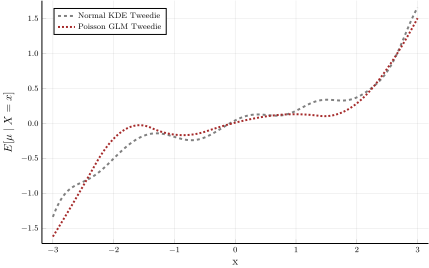

In [10]:
prostate_tweedie = plot(x_grid,  [post_mean_bg tweedie_f] , linewidth=2,
        label =["Normal KDE Tweedie" "Poisson GLM Tweedie"],
        linestyle=[:dash :dot], color=[:grey :brown], legend=:topleft,
        xlabel="x", ylabel=L"E[\mu \mid X=x]")

In [16]:
#savefig(prostate_tweedie,"prostate_tweedie.pdf")

# Efron g-model

In [11]:
brad_null =  fit(BradDeconvolveR, Xs, prior_grid=collect(-3.6:0.02:3.6))
brad_non_null =  fit(BradDeconvolveR, Xs, prior_grid=collect(-3.6:0.02:3.6); deltaAt = :nothing, pDegree=10)

BradDeconvolveR([-3.6, -3.58, -3.56, -3.54, -3.52, -3.5, -3.48, -3.46, -3.44, -3.42  …  3.42, 3.44, 3.46, 3.48, 3.5, 3.52, 3.54, 3.56, 3.58, 3.6], [0.000268691, 0.000254223, 0.000240553, 0.000227654, 0.000215498, 0.000204055, 0.000193297, 0.000183192, 0.000173712, 0.000164827  …  0.000137384, 0.000136955, 0.000136525, 0.000136095, 0.000135665, 0.000135235, 0.000134805, 0.000134376, 0.000133948, 0.00013352], [8.18226e-5, 7.8088e-5, 7.45189e-5, 7.11089e-5, 6.78519e-5, 6.47422e-5, 6.17743e-5, 5.89426e-5, 5.62422e-5, 5.36678e-5  …  2.35872e-5, 2.57159e-5, 2.78507e-5, 2.99891e-5, 3.21284e-5, 3.4266e-5, 3.63994e-5, 3.85262e-5, 4.06438e-5, 4.27499e-5], [1.10904e-9 1.10324e-9 … 2.38042e-10 2.37964e-10; 1.10324e-9 1.1039e-9 … 2.202e-10 2.19999e-10; … ; 2.38042e-10 2.202e-10 … 3.80578e-9 3.90402e-9; 2.37964e-10 2.19999e-10 … 3.90402e-9 4.0059e-9])

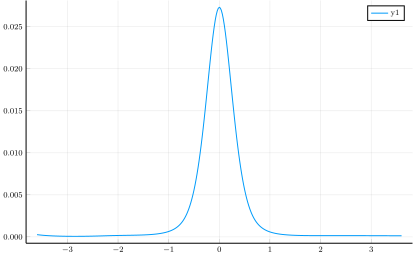

In [12]:
plot(brad_non_null.prior_grid, brad_non_null.g_prior)

In [17]:
x_grid = collect(range(-3, stop=3,length=401))
post_mean_brad_null = [estimate(brad_null, PosteriorTarget(PosteriorMeanNumerator(x))) for x in x_grid];
post_mean_brad_non_null = [estimate(brad_non_null, PosteriorTarget(PosteriorMeanNumerator(x))) for x in x_grid];

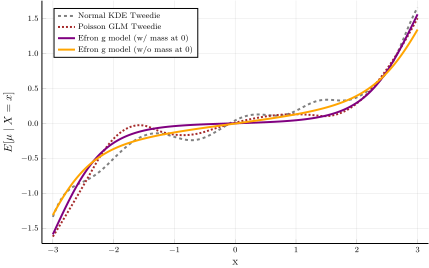

In [18]:
prostate_post_mean_gmodel = plot(x_grid,  [post_mean_bg tweedie_f post_mean_brad_null post_mean_brad_non_null] , linewidth=2,
        label =["Normal KDE Tweedie" "Poisson GLM Tweedie" "Efron g model (w/ mass at 0)" "Efron g model (w/o mass at 0)"],
        linestyle=[:dash :dot :solid :solid], color=[:grey :brown :purple :orange], legend=:topleft,
        xlabel="x", ylabel=L"E[\mu \mid X=x]")

In [32]:
#savefig(prostate_post_mean_gmodel, "prostate_post_mean_gmodel.pdf")

In [35]:
savefig(prostate_lfsr,"prostate_lfsr.pdf",)

# Start with Minimax Calibrator

Construct the random splits for our CEB method:

In [21]:
Random.seed!(200)
Xs = prostz
n_total = length(Xs)
n_half = ceil(Int, n_total/2)
idx_test = sample(1:n_total, n_half, replace=false)
idx_train = setdiff(1:n_total, idx_test)
Xs_train = Xs[idx_train]
Xs_test = Xs[idx_test];

In [22]:
extrema(Xs_train), extrema(Xs_test)

((-4.423917778811027, 4.834436445119715), (-4.287455758560083, 5.291963617005193))

# Quick test 

In [24]:
target = PosteriorTarget(PosteriorMeanNumerator(1.0))

efron_g_train =  fit(BradDeconvolveR, Xs_train, prior_grid=range(-3.6, stop=3.6, length=361);
    deltaAt = :nothing, pDegree=10);

In [26]:
ceb_1 = CEB_ci(Xs_train, Xs_test, ds, PosteriorTarget(PosteriorMeanNumerator(2.0)), efron_g_train);

Academic license - for non-commercial use only
Academic license - for non-commercial use only


In [29]:
ceb_1.ci_left, ceb_1.ci_right,ceb_1.calibrated_target, ceb_1.est_target

(0.19478766499322145, 0.4827566708082687, 0.33877216790074505, 0.4031429859256615)

Now actually run the above along a grid.

In [30]:
xs = Float64.(collect(-3:0.25:3));

In [32]:
#ceb_posterior_mean = [CEB_ci(Xs_train, Xs_test, 
                                 ds, PosteriorTarget(PosteriorMeanNumerator(x)), efron_g_train) for x in xs];
#JLD2.@save "cached_results/ceb_prostate_posterior_mean.jld2" ceb_posterior_mean
JLD2.@load "cached_results/ceb_prostate_posterior_mean.jld2" ceb_posterior_mean

Academic license - for non-commercial use only
Academic license - for non-commercial use only
Academic license - for non-commercial use only
Academic license - for non-commercial use only
Academic license - for non-commercial use only
Academic license - for non-commercial use only
Academic license - for non-commercial use only
Academic license - for non-commercial use only
Academic license - for non-commercial use only
Academic license - for non-commercial use only
Academic license - for non-commercial use only
Academic license - for non-commercial use only
Academic license - for non-commercial use only
Academic license - for non-commercial use only
Academic license - for non-commercial use only
Academic license - for non-commercial use only
Academic license - for non-commercial use only
Academic license - for non-commercial use only
Academic license - for non-commercial use only
Academic license - for non-commercial use only
Academic license - for non-commercial use only
Academic lice

In [37]:
left_ci_post_mean = [t.ci_left for t in ceb_posterior_mean]
right_ci_post_mean =  [t.ci_right for t in ceb_posterior_mean]
point_est_post_mean  = [t.calibrated_target for t in ceb_posterior_mean];
pilot_post_mean = [t.est_target for t in ceb_posterior_mean];

In [38]:
mycols =["#424395" "#EB549A" "#5EC2DA" "#EBC915" "#018AC4"  "#550133"]

1×6 Array{String,2}:
 "#424395"  "#EB549A"  "#5EC2DA"  "#EBC915"  "#018AC4"  "#550133"

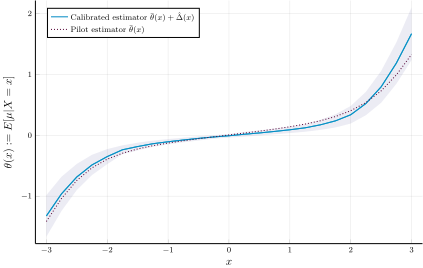

In [40]:
plot(xs, [point_est_post_mean point_est_post_mean],
          fillrange=[left_ci_post_mean right_ci_post_mean],
          fillalpha=0.1, fillcolor=mycols[1],
          label="", 
          color=[mycols[3] mycols[3]],
          line=([:solid :solid]),
          ylabel=L"\theta(x) := E[\mu | X=x]",
          xlabel=L"x")
plot!(xs, [point_est_post_mean pilot_post_mean],
          line=([:solid :dot]),
          color=[mycols[5] mycols[6]], #marker=:circlemmarkerstrokealpha =0,
          legend=:topleft, 
          label=[L"Calibrated estimator $\bar{\theta}(x) + \hat{\Delta}(x)$" L"Pilot estimator $\bar{\theta}(x)$"])

# Posterior Mean plots

## Comte Butucea pilot

## Calibrator pilot

## Actually let us rerun the above but with larger prior variance

In [74]:
std(Xs), sqrt(0.2^2+1), sqrt(0.3^2+1), sqrt(0.5^2+1) #kind of unreasonable but..

(1.1351290243788306, 1.019803902718557, 1.044030650891055, 1.118033988749895)